# Acrobot Test
The aim of this nb is to investigate *why* conformal calibration fails on the Acrobot environment. Two current hypotheses are:

1. Acrobot is a particularly chaotic environment - small changes in the dynamics lead to drastically different vistation patterns, so the calibration is all in the constant fallback region and does nothing
2. The calibration actually *is* working, but the optimal reward on Acrobot varies massively

To test these hypotheses, I want to do the following:
1. Look at the state-space visitation rate of a typical Acrobot policy, and compute the distance between the visitation on Acrobot (maybe a TV distance), compared to Cartpole. Sidenote, how do I guarantee that the distances are comparable? Standardise per-dimension?
2. Train a new agent from scratch for each shifted environment, and see how the reward it achieves varies compared to the nominally-trained policy.

In [1]:
# step 1
#   train DQN on the nominal env
#   track state-space occupancy
#

In [2]:
# from crl.agents import learn_dqn_policy
from stable_baselines3 import DQN
from crl.env import instantiate_eval_env
from crl.agents.dqn import instantiate_vanilla_dqn
import numpy as np
from stable_baselines3.common.vec_env import VecEnv
import matplotlib.pyplot as plt

In [31]:
env_name = "Acrobot-v1"
seed = 5
trainsteps = 100_000

model = instantiate_vanilla_dqn(env_name, seed)
model.learn(total_timesteps=trainsteps, progress_bar=True)
# eval_env = instantiate_eval_env('Acrobot-v1', seed=5)

Output()

In [32]:
def observe_occupancy(model: DQN, vec_env: VecEnv, obs_steps: int = 10_000):
    state_dim = vec_env.observation_space.shape[0]
    obs = vec_env.reset()
    states = np.zeros((obs_steps, state_dim))

    for t in range(obs_steps):
        action = model.policy.predict(obs)
        obs, reward, done, info = vec_env.step(action[0])

        states[t] = obs.flatten()

        if done:  # reset and just keep running episodes
            obs = vec_env.reset()

    return states

In [33]:
vec_env = model.get_env()
states = observe_occupancy(model, vec_env)

In [ ]:
from matplotlib.figure import Figure


def plot_states(
    states,
    xlim: tuple[float] | tuple[None] = (None, None),
    ylim: tuple[float] | tuple[None] = (None, None),
) -> Figure:
    n_dims = states.shape[1]
    fig, axes = plt.subplots(n_dims, n_dims, figsize=(12, 12))

    for x, y in np.ndindex((n_dims, n_dims)):
        ax = axes[x, y]
        if x == y:
            ax.hist(states[:, x], bins=50)
        else:
            ax.scatter(states[:, x], states[:, y], alpha=0.01, s=3)

        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
    return fig

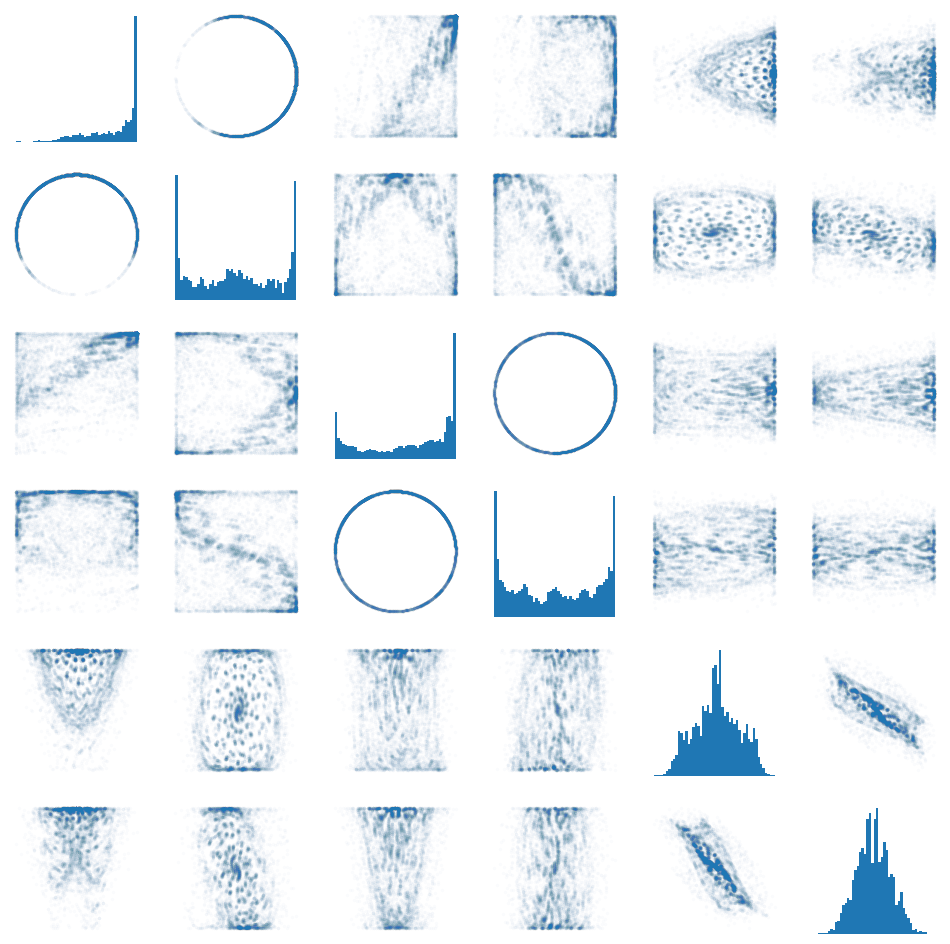

In [58]:
# nominal states
plot_states(states)
plt.show()

In [59]:
# eval env states
eval_env = instantiate_eval_env(env_name, seed, LINK_LENGTH_1=1.1)
eval_states = observe_occupancy(model, eval_env)

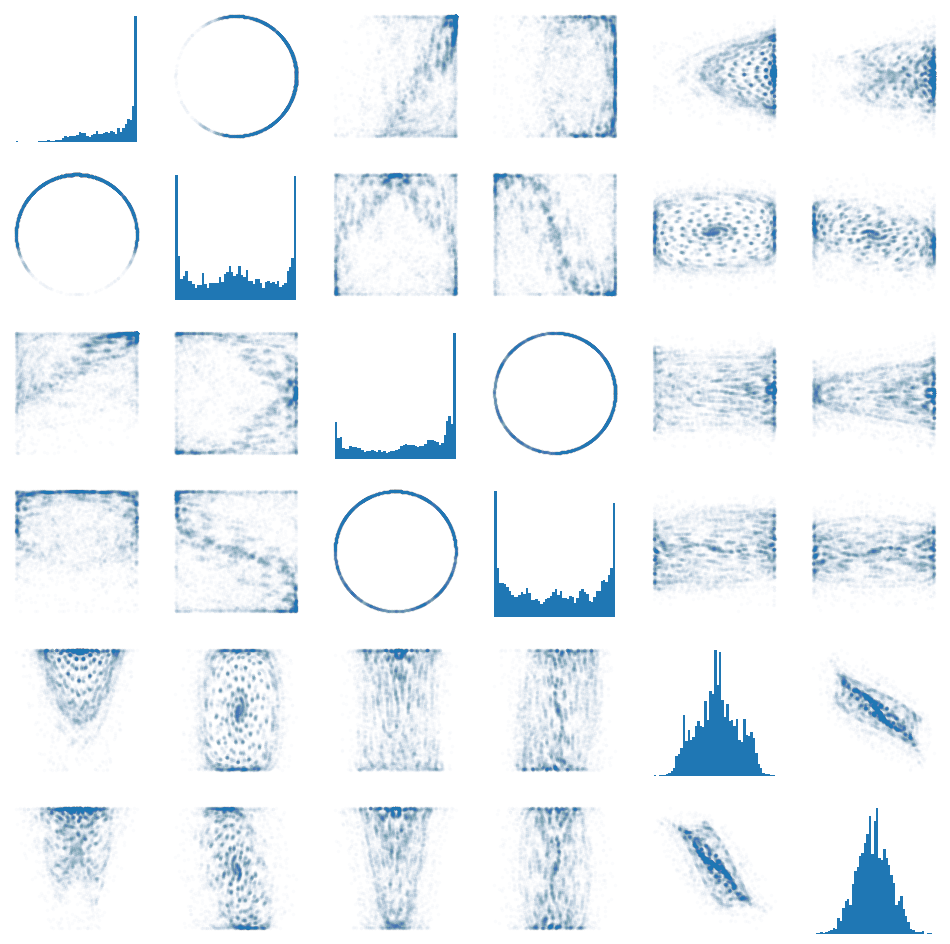

In [61]:
plot_states(eval_states)
plt.show()

In [ ]:
# generate gif over changing parameter values
for ix, param_val in enumerate(np.arange(0.1, 4.0, 0.025)):
    eval_env = instantiate_eval_env(env_name, seed, LINK_LENGTH_1=param_val)
    eval_states = observe_occupancy(model, eval_env)
    fig = plot_states(eval_states)
    fig.suptitle(f"Acrobot - LINK_LENGTH_1: {param_val:.2f}")
    plt.savefig(f"results/gif/img_{ix + 1}.png", bbox_inches="tight")
    plt.close()

In [ ]:
# save a gif
from PIL import Image

# List your PNG files in the desired order
png_files = [
    f"results/gif/img_{i + 1}.png" for i, _ in enumerate(np.arange(0.1, 4.0, 0.025))
]

# Open the first image
frames = [Image.open(p) for p in png_files]

# Save as GIF
frames[0].save(
    "results/gif/output.gif",
    save_all=True,  # Save as an animation
    append_images=frames[1:],  # The rest of the frames
    duration=50,  # Frame duration in ms
    loop=0,  # 0 = infinite loop
)

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
scaler = StandardScaler()
scaler.fit(states)

,copy,True
,with_mean,True
,with_std,True


Text(0.5, 1.0, 'Standardised distance - between nominal and eval states')

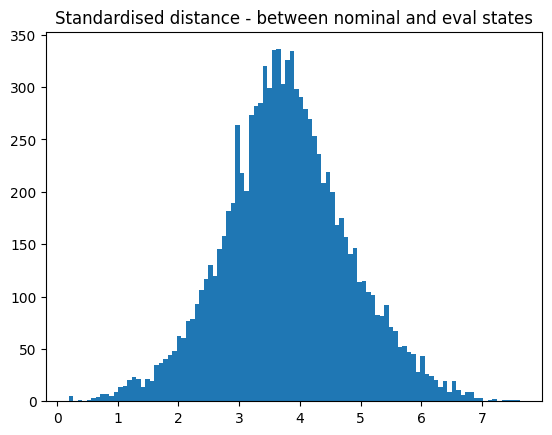

In [ ]:
states_sc = scaler.transform(states)
eval_states_sc = scaler.transform(eval_states)
plt.hist(np.linalg.norm(states_sc - eval_states_sc, axis=1), bins=100)
plt.title("Standardised distance - between nominal and eval states")

In [14]:
env_name = "CartPole-v1"
seed = 5
trainsteps = 50_000
model = instantiate_vanilla_dqn(env_name, seed)
model.learn(total_timesteps=trainsteps, progress_bar=True)

Output()

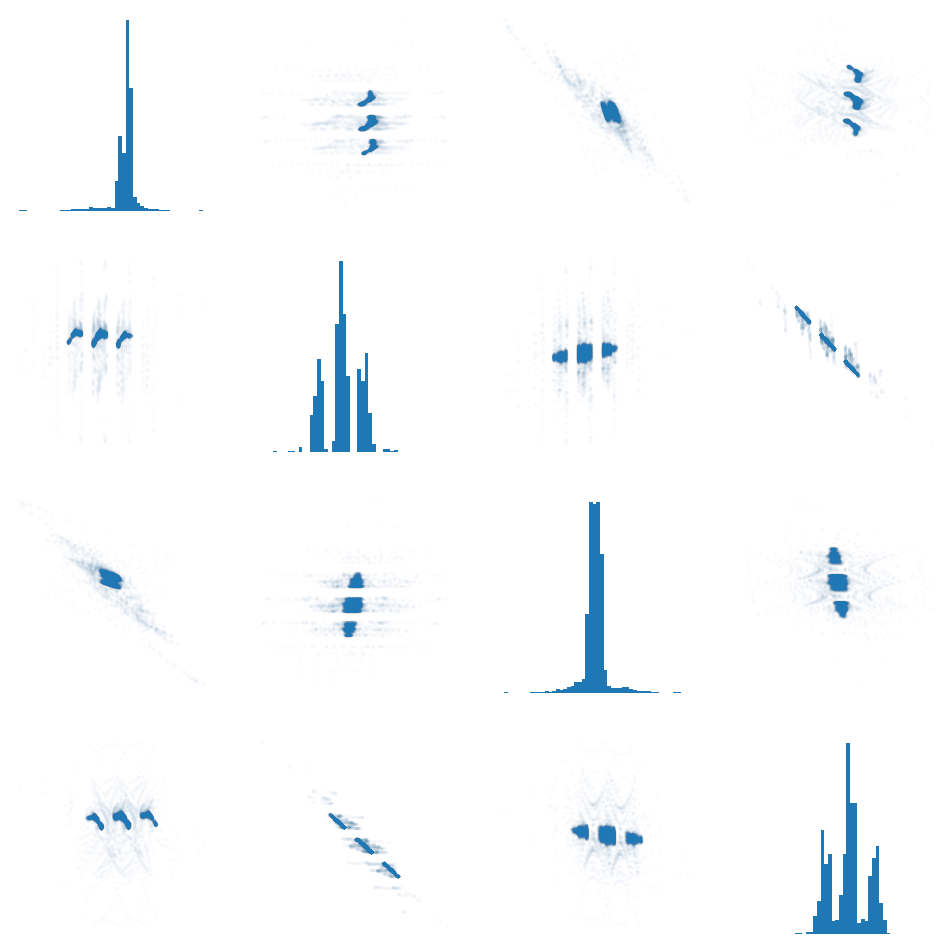

In [15]:
vec_env = model.get_env()
states = observe_occupancy(model, vec_env)
plot_states(states)

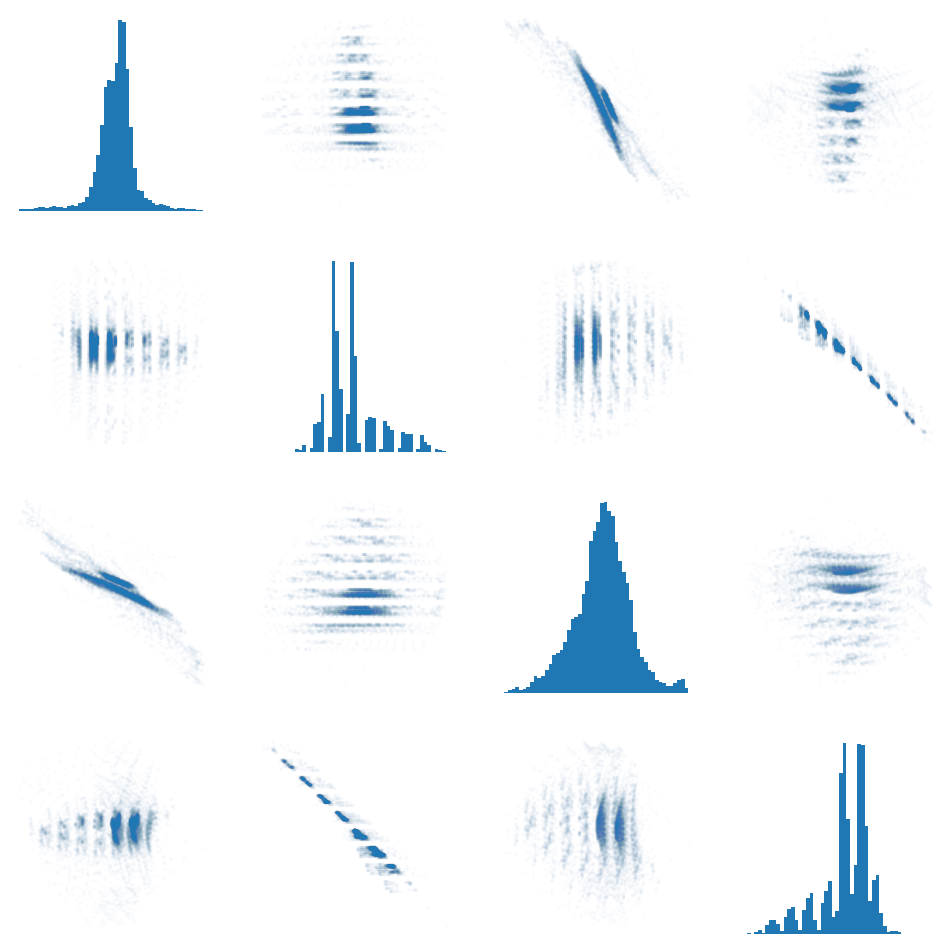

In [16]:
# eval env states
eval_env = instantiate_eval_env(env_name, seed, length=0.8)
eval_states = observe_occupancy(model, eval_env)
plot_states(eval_states)

Text(0.5, 1.0, 'Standardised distance - between nominal and eval states')

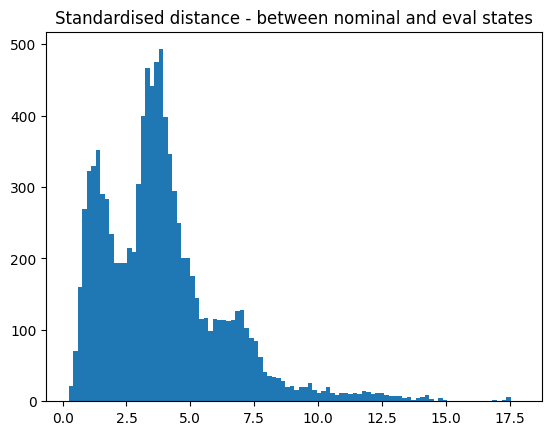

In [ ]:
scaler = StandardScaler()
scaler.fit(states)
states_sc = scaler.transform(states)
eval_states_sc = scaler.transform(eval_states)
plt.hist(np.linalg.norm(states_sc - eval_states_sc, axis=1), bins=100)
plt.title("Standardised distance - between nominal and eval states")